In [5]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm

%matplotlib inline

In [6]:
class Holt_Winters:
    __doc__ = '''
    Holt Winters prediction method for time-series.
    
    Attributes:
    ----------
    data = set of data. Compatible with a numpy array. 
    alpha, gamma, delta = smoothing parameters for the current level, trend, and seasonal index. standard values are alpha = 0.4, gamma = 0.1, delta = 0.4.
    p = expected period. default value p = 4 for quarterly data. insert p = 12 for monthly data, p = 7 for weekly data. 
    seasonality = type of expected seasonality. standard is 'multiplicative'. The alternatives are 'additive' and False (if there is no seasonality; in this case delta and p are not required)
    '''

    def __init__(self, data, alpha = 0.4, gamma = 0.1, delta = 0.4, p = 4, seasonality = 'multiplicative'):
        self.data = data
        self.alpha = alpha
        self.gamma = gamma
        self.delta = delta
        self.p = p
        self.seasonality = seasonality
    
    def add_point(self, d):
        """
        Adds one data point to the data set.
        """
        self.data = np.append(self.data,d)
    
    def set_alpha(self, alpha):
        """
        Manually set the value of alpha
        """
        self.alpha = alpha
        
    def set_gamma(self, gamma):
        """
        Manually set the value of gamma
        """
        self.gamma = gamma
        
    def set_delta(self, delta):
        """
        Manually set the value of delta
        """
        self.delta = delta
        
    def set_period(self, p):
        """
        Manually set the value of p
        """
        self.p = p
    
    def set_L0(self, L0):
        """
        Manually set the initial value of the current level
        """        
        self.L0 = L0

    def set_T0(self, T0):
        """
        Manually set the initial value of the current trend
        """      
        self.T0 = T0
        
    def set_I0(self, I0):
        """
        Manually set the initial value of the seasonal index. I0 is an array of p elements.
        """      
        self.I0 = I0
        
    def auto_L0(self):
        """
        Automatically set the initial value of the current level to the average of the first p observations.
        If seasonality == False, p is set to 3.
        """
        if self.seasonality != False:
            self.L0 = np.average(self.data[:self.p])
        else:
            self.L0 = np.average(self.data[:3])
 
    def auto_T0(self):
        """
        Automatically set the initial value of the trend to 0.
        """          
        self.T0 = 0
        
    def auto_I0(self):
        """
        Automatically set the initial value of the seasonal index so that the average for the first p observations is either 1 (multiplicative case) or 0 (additive case).
        """  
        if self.seasonality == 'multiplicative':
            X1av = np.average(self.data[:self.p])
            self.I0 = self.data[:self.p]/X1av
        elif self.seasonality == 'additive':
            X1av = np.average(self.data[:self.p])
            self.I0 = self.data[:self.p]-X1av
        
    def normalise_I(self, I, k):
        """
        Normalise the seasonal index for the observations p-1, ..., p-k.
        The seasonal index averages to 1 in the multiplicative case, 0 in the additive case.
        """          
        p = self.p
        if k >= p and self.seasonality == 'multiplicative':
            I_av = np.sum(I[k-p : k])/p
            for k in range(k-p,k):
                I[k] = I[k] / I_av
        elif k >= p and self.seasonality == 'additive':
            I_av = np.sum(I[k-p : k])/p
            for k in range(k-p,k):
                I[k] = I[k] - I_av
        return I
        

    def fit(self, alpha = None, gamma = None, delta = None, normalise = False):
        """
        Calculates L[t], T[t], and I[t] for the data. Uses standard Holt-Winters formulas for the seasonal cases and the non-seasonal case.
        alpha, gamma, delta = smoothing parameters. If not specified, the ones contained in the regressor object are used.
        normalise = whether to normalise the seasonal index at each step. standard is False.
        
        Sets the values of L, T, I, and the one-step-ahead predictions for the data, OSA_values. 
        """
        n = len(self.data)

        if self.seasonality == 'multiplicative':
            if alpha is None:
                alpha = self.alpha
            if gamma is None:
                gamma = self.gamma
            if delta is None:
                delta = self.delta
            
            p = self.p
        
            L = np.zeros(n)
            T = np.zeros(n)
            I = np.zeros(n)
            OSA_values = np.zeros(n)
        
            L[0] = alpha*(self.data[0] / self.I0[0]) + (1 - alpha)*(self.L0 + self.T0)
            T[0] = gamma*(L[0]-self.L0) + (1-gamma)*self.T0
            I[0] = delta*(self.data[0] / L[0]) + (1 - delta)*self.I0[0]
            OSA_values[0] = (self.L0 + self.T0)*self.I0[0]

            for k in range(1,p):
                L[k] = alpha*(self.data[k] / self.I0[k]) + (1 - alpha)*(L[k-1] + T[k-1])
                T[k] = gamma*(L[k]-L[k-1]) + (1-gamma)*T[k-1]
                I[k] = delta*(self.data[k] / L[k]) + (1 - delta)*self.I0[k]
                OSA_values[k] = (L[k-1] + T[k-1])*self.I0[k] 

            for k in range(p,n):
                L[k] = alpha*(self.data[k] / I[k-p]) + (1 - alpha)*(L[k-1] + T[k-1])
                T[k] = gamma*(L[k]-L[k-1]) + (1-gamma)*T[k-1]
                I[k] = delta*(self.data[k] / L[k]) + (1 - delta)*I[k-p]
                OSA_values[k] = (L[k-1] + T[k-1])*I[k-p] 
                if normalise == True:
                    I = self.normalise_I(I,k)
     
            self.L = L
            self.T = T
            self.I = I
            self.OSA_values=OSA_values
          
        elif self.seasonality == False:
            if alpha is None:
                alpha = self.alpha
            if gamma is None:
                gamma = self.gamma
          
            L = np.zeros(n)
            T = np.zeros(n)
            OSA_values = np.zeros(n)
        
            L[0] = alpha*self.data[0] + (1 - alpha)*(self.L0 + self.T0)
            T[0] = gamma*(L[0]-self.L0) + (1-gamma)*self.T0
            OSA_values[0] = self.L0 + self.T0

            for k in range(1,n):
                L[k] = alpha*self.data[k] + (1 - alpha)*(L[k-1] + T[k-1])
                T[k] = gamma*(L[k]-L[k-1]) + (1-gamma)*T[k-1]
                OSA_values[k] = L[k-1] + T[k-1] 
            
            self.L = L
            self.T = T
            self.OSA_values=OSA_values

        elif self.seasonality == 'additive':
            if alpha is None:
                alpha = self.alpha
            if gamma is None:
                gamma = self.gamma
            if delta is None:
                delta = self.delta
            
            p = self.p
        
            L = np.zeros(n)
            T = np.zeros(n)
            I = np.zeros(n)
            OSA_values = np.zeros(n)
        
            L[0] = alpha*(self.data[0] - self.I0[0]) + (1 - alpha)*(self.L0 + self.T0)
            T[0] = gamma*(L[0]-self.L0) + (1-gamma)*self.T0
            I[0] = delta*(self.data[0] - L[0]) + (1 - delta)*self.I0[0]
            OSA_values[0] = self.L0 + self.T0 + self.I0[0]

            for k in range(1,p):
                L[k] = alpha*(self.data[k] - self.I0[k]) + (1 - alpha)*(L[k-1] + T[k-1])
                T[k] = gamma*(L[k]-L[k-1]) + (1-gamma)*T[k-1]
                I[k] = delta*(self.data[k] - L[k]) + (1 - delta)*self.I0[k]
                OSA_values[k] = L[k-1] + T[k-1]+self.I0[k] 

            for k in range(p,n):
                L[k] = alpha*(self.data[k] - I[k-p]) + (1 - alpha)*(L[k-1] + T[k-1])
                T[k] = gamma*(L[k]-L[k-1]) + (1-gamma)*T[k-1]
                I[k] = delta*(self.data[k] - L[k]) + (1 - delta)*I[k-p]
                OSA_values[k] = L[k-1] + T[k-1] + I[k-p] 
                if normalise == True:
                    I = self.normalise_I(I,k)
     
            self.L = L
            self.T = T
            self.I = I
            self.OSA_values=OSA_values
                
            
    def MSE_fit(self, start = None, alpha = None, gamma = None, delta = None):
        """
        Calculates the mean squared error of the fit starting from a certain data point to the last data point. 
        Typically starts after two periods have occurred.
        start = first observation from which the error is calculated. If None, 2*p + 1 is used in the seasonal cases, 3 otherwise.
        alpha, gamma, delta = smoothing parameters. If not specified, the ones contained in the regressor object are used.
        """
        if start == None and self.seasonality != False:
            start = 2*self.p
        elif start == None:
            start = 3

        if alpha is None:
            alpha = self.alpha
            
        if gamma is None:
            gamma = self.gamma

        if delta is None:
            delta = self.delta
           
        n_steps = len(self.data[start:])
        
        self.fit(alpha, gamma, delta)
        resid = self.OSA_values[start:] - self.data[start:]
        return np.sum(resid**2)/len(self.data[start:])
        
    def auto_set_params(self, start = None):
        """
        Automatically sets values of alpha, gamma, delta.
        A grid of values is constructed and the values that correspond to the minimum MSE of the fit are selected.
        alpha is between 0.1 and 0.9, gamma is between 0.05 and 0.3, delta is between 0.1 and 0.9.
        start = first observation from which the error is calculated.
        """
        grid = np.zeros((17*11*17,4))
        k = 0
        results = np.zeros((17*11*17,4))
        for a in range(2,19):
            for b in range(2,13):
                for c in range(2,19):
                    alpha = 0.05*a
                    gamma = 0.025*b
                    delta = 0.05*c
                    
                    results[k] = np.array([alpha,gamma,delta,self.MSE_fit(start, alpha, gamma, delta)])
                    k = k+1
        results = results[results[:,3].argsort()]
        self.alpha = results[0,0]
        self.gamma = results[0,1]
        self.delta = results[0,2]
        self.grid = results
        return np.array([alpha,gamma,delta])
    
    def predict(self,n):
        """
        n-step-ahead predictions for the data. 
        """
        predictions = np.zeros(n)
        if self.seasonality == 'multiplicative':
            for k in range(n):
                predictions[k] = (self.L[-1]+(k+1)*self.T[-1])*self.I[-self.p+k]
        elif self.seasonality == 'additive':
            for k in range(n):
                predictions[k] = self.L[-1]+(k+1)*self.T[-1]+self.I[-self.p+k]
        elif self.seasonality == False:
            for k in range(n):
                predictions[k] = self.L[-1]+(k+1)*self.T[-1]
        return predictions
        
   

### Implementation on Tractor Sales data

In [13]:
import pandas as pd
sales_data = pd.read_csv("Tractor-Sales.csv")
sales_data.tail(5)

,Month-Year,Number of Tractor Sold
139,Aug-14,848
140,Sep-14,640
141,Oct-14,581
142,Nov-14,519
143,Dec-14,605


In [14]:
date_range_val = pd.date_range(start='2003-01-01', freq='MS', periods=len(sales_data))

In [15]:
sales_data.set_index(date_range_val, inplace=True)

In [16]:
sales_data.columns = ['Month_Year', 'Tractor_Sales']

In [17]:
sales_ts = sales_data.Tractor_Sales

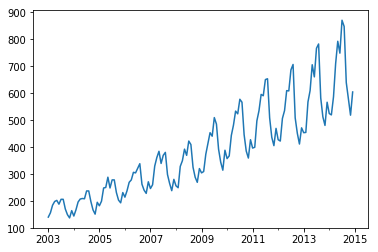

In [18]:
sales_ts.plot()

In [54]:
HWregressor = Holt_Winters(sales_ts,seasonality='multiplicative',p=12)
HWregressor.auto_I0()
HWregressor.auto_L0()
HWregressor.auto_T0()
HWregressor.auto_set_params()
HWregressor.fit(normalise=False)

In [55]:
print(HWregressor.predict(12))

[562.94207744 558.23468073 651.14655524 765.59958078 853.92641571
 806.99226161 935.69669095 923.75025939 696.19192369 624.00846799
 561.03763277 654.44706965]


In [56]:
print(HWregressor.alpha, HWregressor.gamma, HWregressor.delta)

0.30000000000000004 0.05 0.9


In [57]:
### ETS Models using statsmodel package using above values

In [58]:
#ETS Models
### single exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# our guessed parameters
alpha = 0.30000000000000004
beta = 0.05
gamma = 0.9

# initialise model
ets_model = ExponentialSmoothing(sales_ts, trend='mul', seasonal='mul', seasonal_periods=12)
ets_fit = ets_model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)

In [59]:
# forecast p months ahead
p_ahead = 12
fcast = ets_fit.forecast(p_ahead)

In [60]:
fcast

2015-01-01    562.477658
2015-02-01    558.460850
2015-03-01    638.508157
2015-04-01    783.408766
2015-05-01    864.228644
2015-06-01    813.761756
2015-07-01    943.930762
2015-08-01    924.143619
2015-09-01    706.350085
2015-10-01    642.776061
2015-11-01    572.911666
2015-12-01    684.593475
Freq: MS, dtype: float64

The values are slightly get deviated from both methods however the values will be similar. THe first method help to calculate best values of alpha, beta and gamma. We will use statsmodel package to get final model accuarcy